In [1]:
%matplotlib inline
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS, Isomap

from sklearn.decomposition import PCA, KernelPCA

import torch
from torch.utils.data import DataLoader
#from torchvision.datasets import MNIST
from torchvision import transforms

from src.datasets.mnist import MNIST
from src.datasets.splitting import split_dataset

#from src.models import TopologicallyRegularizedAutoencoder

torch.manual_seed(42)

In [2]:
# LOAD DATASET:
dataset = MNIST(train=True)

In [3]:
# SPLIT DATASET:
val_size = 0.2
batch_size = 64

train_loader, validation_loader, test_loader = split_dataset(dataset, val_size, batch_size)


In [4]:
# CHOOSE SPLIT:
dataloader = train_loader #validation_loader 

In [5]:
def get_latent_space(model, dataloader):
        
    #ensure that seed is correct (despite several function calls)
    torch.manual_seed(42)
    
    full_latent_space = []
    all_labels = []

    for index, batch in enumerate(dataloader):
        image, label = batch
        #latent, reconst = model(image)
        latent = model.encode(image)
        reconst = model.decode(latent)

        latent = latent.detach().numpy()        
        reconst = reconst.detach().numpy()
        latent_flat = latent.reshape(-1, latent.shape[0]).T
        
        full_latent_space.append(latent_flat)
        all_labels.append(label)

        #if index == 199:
        #    break

    full_latent_space = np.concatenate(full_latent_space, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return [full_latent_space, all_labels]

In [6]:
#Extract full data space for baseline t-sne:
full_data_space = []
all_labels = []
torch.manual_seed(42)
for index, batch in enumerate(dataloader):
    image, label = batch
    im = image.detach().numpy()
    im_flat = im.reshape(-1, im.shape[0]).T
    full_data_space.append(im_flat)
    all_labels.append(label)
    #if index == 50:
    #    break
    
full_data_space = np.concatenate(full_data_space, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [28]:
from sklearn.preprocessing import StandardScaler
scaled_data_space = StandardScaler().fit_transform(full_data_space)

In [7]:
# LOAD ALL MODELS AND GET LATENT SPACES
methods = ['topological','vanilla'] #'surrogate'
model_paths = {methods[0]: '../runs/mnist/6/model.pth', #1=10 epochs, 6=50   
                methods[1]: '../runs/mnist/5/model.pth' #3=10 epochs, 5=50
              } #methods[2]: '../runs/mnist/2/model.pth',

latent_spaces = {}

for method in methods:    
    model = torch.load(model_paths[method])
    
    # GET LATENT SPACES:
    Z, _labels = get_latent_space(model, dataloader)
    #ensure that _labels are identical to all_labels, due to seed issues:
    if (all_labels != _labels).sum() > 0:
        raise ValueError('Labels are not consistent! Fix seeds!')
    latent_spaces[method] = {'data': Z, 'labels': _labels}

In [19]:
n_samples = 500

In [36]:
tsne = TSNE(random_state=42, n_iter=1000, perplexity=40) #, perplexity=10, learning_rate=100, early_exaggeration=30)
Z_tsne_top = tsne.fit_transform(latent_spaces['topological']['data'][:n_samples,:])

tsne = TSNE(random_state=42, n_iter=1000, perplexity=40) #, perplexity=10, learning_rate=100)
Z_tsne_van = tsne.fit_transform(latent_spaces['vanilla']['data'][:n_samples,:])

tsne = TSNE(random_state=42, n_iter=1000, perplexity=40) #, perplexity=10, learning_rate=100)
X_tsne = tsne.fit_transform(scaled_data_space[:n_samples,:])

In [32]:
pca = PCA(random_state=0)
Z_pca_top = pca.fit_transform(latent_spaces['topological']['data'][:n_samples,:])
pca = PCA(random_state=0)
Z_pca_van = pca.fit_transform(latent_spaces['vanilla']['data'][:n_samples,:])
pca = PCA(random_state=0)
X_pca = pca.fit_transform(scaled_data_space[:n_samples,:])

In [27]:
full_data_space.mean(axis=0)

array([-0.999444  , -0.96696323, -0.7329789 , -0.6173505 , -0.5916828 ,
       -0.5611706 , -0.60617346, -0.64774096, -0.5741591 , -0.6310011 ,
       -0.8378355 , -0.9741675 , -0.9993815 , -0.98629874, -0.8539503 ,
       -0.5895056 , -0.58427626, -0.6752163 , -0.5847918 , -0.5427111 ,
       -0.67230433, -0.66036624, -0.7209383 , -0.9700687 , -0.9991508 ,
       -0.9953063 , -0.8449057 , -0.66417605, -0.63677454, -0.5973281 ,
       -0.56942636, -0.6441584 , -0.63538367, -0.54973197, -0.7374807 ,
       -0.93111956, -0.9924492 , -0.9966738 , -0.94188434, -0.71717477,
       -0.5214634 , -0.6687862 , -0.65118164, -0.5276529 , -0.60604316,
       -0.6610255 , -0.6578998 , -0.86881787, -0.9924544 , -0.9995731 ,
       -0.9562984 , -0.73430943, -0.6286135 , -0.61179626, -0.58271873,
       -0.61053437, -0.6319467 , -0.56306034, -0.6278614 , -0.849129  ,
       -0.97479755, -0.99877214, -0.9856276 , -0.8607976 , -0.5782396 ,
       -0.5722499 , -0.6767484 , -0.570235  , -0.5430617 , -0.66

In [11]:
def plotting(transformed, all_labels, title):
    color_mapping = matplotlib.cm.rainbow(np.linspace(0, 1, 10))
    distinct_labels = np.unique(all_labels)
    colors = [color_mapping[cl] for cl in distinct_labels]
    for i, label in enumerate(distinct_labels):
        mask = (all_labels == label).astype(int)
        inds = list(np.where(mask)[0])
        plt.scatter(transformed[inds, 0], transformed[inds, 1], c=[colors[i]], label=label, s=2)
    plt.title(title)
    lgnd = plt.legend(loc="lower left")
    for i,_ in enumerate(distinct_labels):
        lgnd.legendHandles[i]._sizes = [30]

In [301]:
#shuff_labels = all_labels.copy()
#np.random.shuffle(shuff_labels)

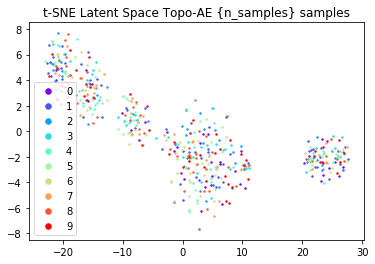

In [37]:
plotting(Z_tsne_top, all_labels[:n_samples], 't-SNE Latent Space Topo-AE {n_samples} samples')


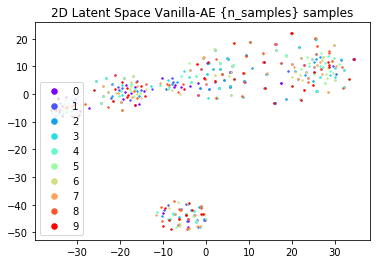

In [38]:
plotting(Z_tsne_van, all_labels[:n_samples], '2D Latent Space Vanilla-AE {n_samples} samples')

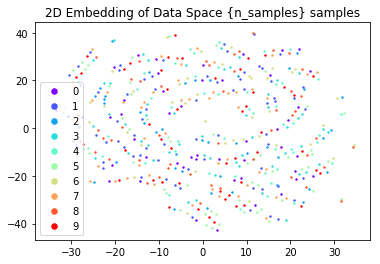

In [39]:
plotting(X_tsne, all_labels[:n_samples], '2D Embedding of Data Space {n_samples} samples')

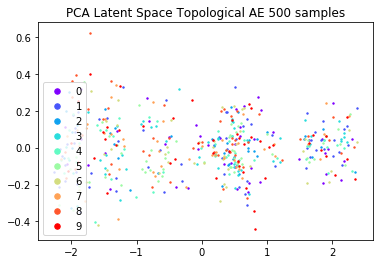

In [40]:
plotting(Z_pca_top, all_labels[:n_samples], f'PCA Latent Space Topological AE {n_samples} samples')

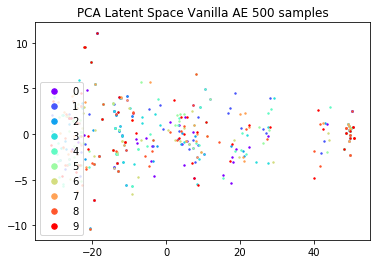

In [41]:
plotting(Z_pca_van, all_labels[:n_samples], f'PCA Latent Space Vanilla AE {n_samples} samples')

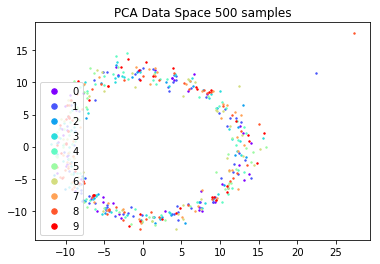

In [42]:
plotting(X_pca, all_labels[:n_samples], f'PCA Data Space {n_samples} samples')

In [ ]:
# Latent Space Evaluation Scenario:



# BELOW HERE IS OLDER STUFF


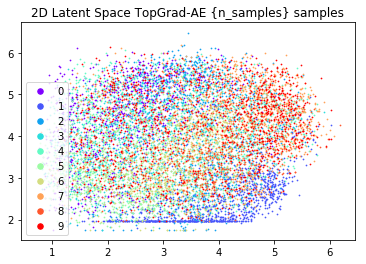

In [15]:
plotting(top_latent_space[:n_samples,:], grad_top_labels[:n_samples], '2D Latent Space TopGrad-AE {n_samples} samples')

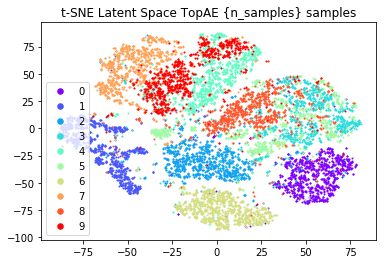

In [89]:
plotting(Z_tsne_top, top_labels[:n_samples], 't-SNE Latent Space TopAE {n_samples} samples')

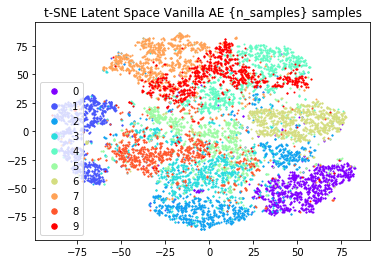

In [90]:
plotting(Z_tsne_van, van_labels[:n_samples], 't-SNE Latent Space Vanilla AE {n_samples} samples')

In [ ]:
mds = MDS(n_components=2)
Z_mds_top = mds.fit_transform(top_latent_space[:n_samples,:])
mds = MDS(n_components=2)
Z_mds_van = mds.fit_transform(vanilla_latent_space[:n_samples,:])

In [ ]:
mds = MDS(n_components=2)
X_mds = mds.fit_transform(full_data_space[:n_samples,:])

In [ ]:
isomap = Isomap(n_components=2)
Z_isomap = isomap.fit_transform(X[:100])

In [27]:
kpca = KernelPCA(kernel="rbf", gamma=1)
Z_kpca = kpca.fit_transform(full_latent_space[:n_samples,:])



In [ ]:
plotting(Z_mds_top, top_labels[:n_samples], f'MDS Latent Space Topological AE {n_samples} samples')

In [ ]:
plotting(Z_mds_van, van_labels[:n_samples], f'MDS Latent Space Vanilla AE {n_samples} samples')

In [ ]:
plotting(X_mds, all_labels[:n_samples], f'MDS Data Space {n_samples} samples')